In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import datetime as dt

warnings.filterwarnings('ignore')

# Set the working directory
os.chdir('/Users/dsagher/Library/CloudStorage/Dropbox/Documents/school/fall 2025/CMSE 830/midterm_project_2')

In [2]:
# Load datasets

df_geo = pd.read_csv('./data/raw/olist_geolocation_dataset.csv')
df_order = pd.read_csv('./data/raw/olist_orders_dataset.csv')
df_order_item = pd.read_csv('./data/raw/olist_order_items_dataset.csv')
df_order_payment = pd.read_csv('./data/raw/olist_order_payments_dataset.csv')
df_order_review = pd.read_csv('./data/raw/olist_order_reviews_dataset.csv')
df_product = pd.read_csv('./data/raw/olist_products_dataset.csv')
df_seller = pd.read_csv('./data/raw/olist_sellers_dataset.csv')
df_product_category = pd.read_csv('./data/raw/product_category_name_translation.csv')
df_customer = pd.read_csv('./data/raw/olist_customers_dataset.csv')


In [3]:
"""
Find nulls
"""
nulls_geo = df_geo.loc[:,(df_geo.isna().sum() > 0).values]
nulls_orders = df_order.loc[:,(df_order.isna().sum() > 0).values]
nulls_order_item = df_order_item.loc[:,(df_order_item.isna().sum() > 0)]
nulls_order_payment = df_order_payment.loc[:,(df_order_payment.isna().sum() > 0)]
nulls_order_review = df_order_review.loc[:,(df_order_review.isna().sum() > 0)]
nulls_product = df_product.loc[:,(df_product.isna().sum() > 0)]
nulls_seller = df_seller.loc[:,(df_seller.isna().sum() > 0)]
nulls_product_category = df_product_category.loc[:,(df_product_category.isna().sum() > 0)]
nulls_customer = df_customer.loc[:,(df_customer.isna().sum() > 0)]

print("Geolocation no nulls: ",nulls_geo.shape[1] == 0)
print("Orders no nulls: ",nulls_orders.shape[1] == 0)
print("Order Item no nulls: ",nulls_order_item.shape[1] == 0)
print("Order Payment no nulls: ",nulls_order_payment.shape[1] == 0)
print("Order Review no nulls: ",nulls_order_review.shape[1] == 0)
print("Product no nulls: ",nulls_product.shape[1] == 0)
print("Seller no nulls: ",nulls_seller.shape[1] == 0)
print("Product Category no nulls: ",nulls_product_category.shape[1] == 0)
print("Customer no nulls: ",nulls_customer.shape[1] == 0)


Geolocation no nulls:  True
Orders no nulls:  False
Order Item no nulls:  True
Order Payment no nulls:  True
Order Review no nulls:  False
Product no nulls:  False
Seller no nulls:  True
Product Category no nulls:  True
Customer no nulls:  True


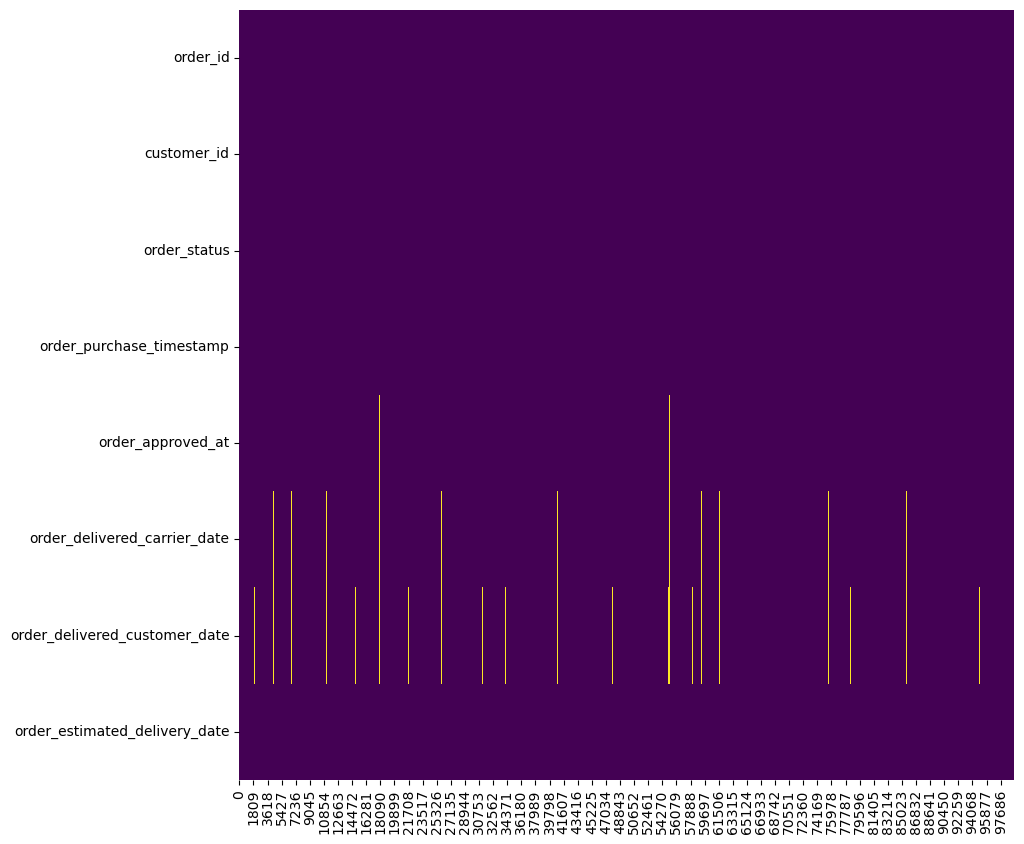

In [4]:
"""
Missing values cluster around dates delivered (carrier and customer)
"""

# Plotting the nulls
fig = plt.figure(figsize=(10,10))
sns.heatmap(df_order.isna().transpose(), cbar=False, cmap='viridis')
plt.show()

#### **Observation:** Missing values cluster around 'order_delivered_customer_date' and 'order_delivered_carrier_date', with some in 'order_approved_at'
#
#### **Next Steps:** Investigate missing values

# Missing Values in 'order_delivered_customer_date' and 'order_delivered_carrier_date'

In [5]:
""" 
Calculate the mean dates for rows with and without missing carrier and carrier dates
"""

# Mask for nulls vs not nulls
carrier_missing_mask = df_order['order_delivered_carrier_date'].isna()
customer_missing_mask = df_order['order_delivered_customer_date'].isna()
carrier_present_mask = df_order['order_delivered_carrier_date'].notna()
customer_present_mask = df_order['order_delivered_customer_date'].notna()

df_order['order_delivered_carrier_date'] = pd.to_datetime(df_order['order_delivered_carrier_date'])
df_order['order_delivered_customer_date'] = pd.to_datetime(df_order['order_delivered_customer_date'])
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'])


# Calculate means
mean_carrier_missing = df_order.loc[carrier_missing_mask, 'order_purchase_timestamp'].mean()
mean_customer_missing = df_order.loc[customer_missing_mask, 'order_purchase_timestamp'].mean()

mean_carrier_present = df_order.loc[carrier_present_mask, 'order_purchase_timestamp'].mean()
mean_customer_present = df_order.loc[customer_present_mask, 'order_purchase_timestamp'].mean()


print("Carrier Missing: ",mean_carrier_missing)
print("Customer Missing:",mean_customer_missing)

print("Carrier Present:",mean_carrier_present)
print("Customer Present:",mean_customer_present)


Carrier Missing:  2017-10-20 11:48:54.219854336
Customer Missing: 2017-11-09 19:24:45.122428160
Carrier Present: 2018-01-01 16:12:46.194085376
Customer Present: 2018-01-01 22:44:47.156474368


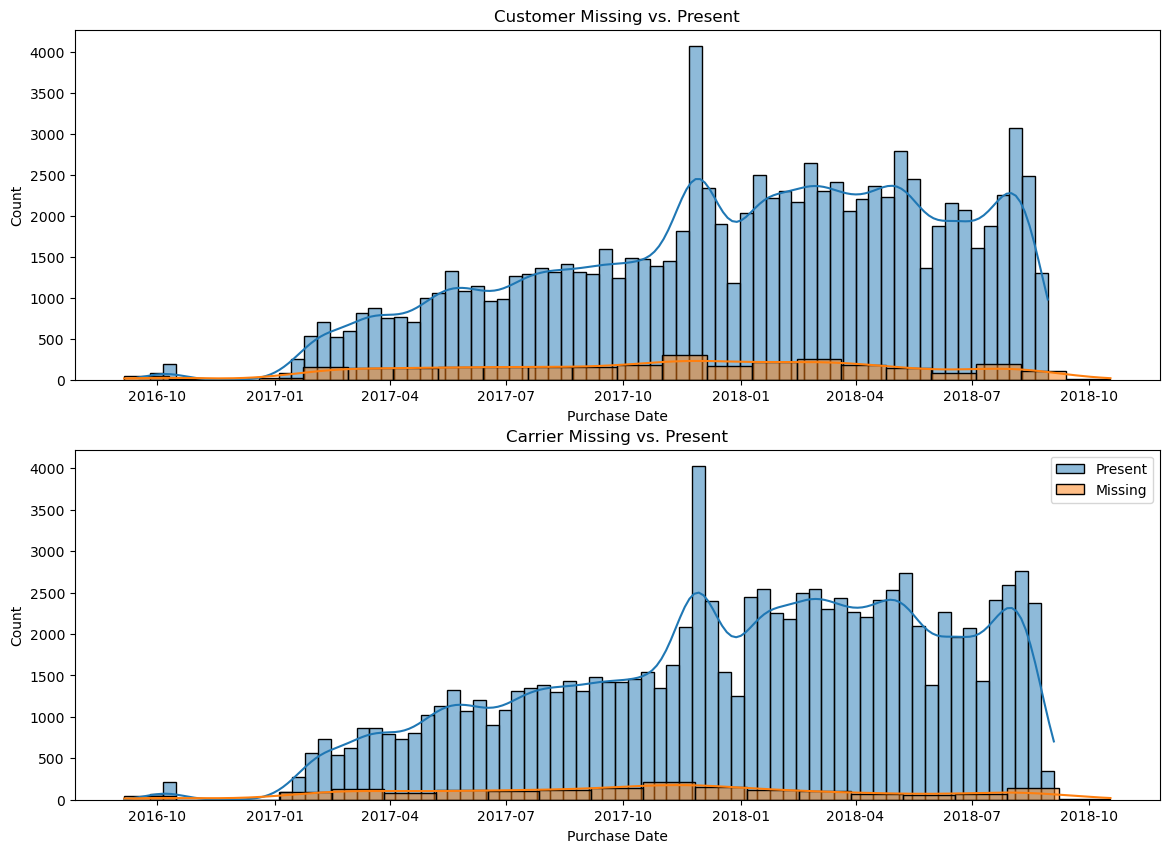

In [6]:
fig, ax = plt.subplots(2,1, figsize=(14,10))

ax[0].set_title("Customer Missing vs. Present")
ax[0].set_xlabel("Purchase Date")
sns.histplot(df_order.loc[customer_present_mask, 'order_purchase_timestamp'], label='Present', kde=True, ax=ax[0])
sns.histplot(df_order.loc[customer_missing_mask, 'order_purchase_timestamp'], label='Missing', kde=True, ax=ax[0])


ax[1].set_title("Carrier Missing vs. Present")
ax[1].set_xlabel("Purchase Date")
sns.histplot(df_order.loc[carrier_present_mask, 'order_purchase_timestamp'], label='Present', kde=True, ax=ax[1])
sns.histplot(df_order.loc[carrier_missing_mask, 'order_purchase_timestamp'], label='Missing', kde=True, ax=ax[1])
plt.legend()
plt.show()

#### **Observations:** The slight increase in missing values appears to be smooth throughout the year, with only a slight increase around the same time that overall orders spike.
#
#### **Hypothesis:** The earlier purchase date average for both customers and carriers is likely due to the spike in purchases, potentially leading to more cancellations or software malfunctions. 
#
#### **Next Steps:** Determine if there are more cancelled orders around the spike to confirm and impute if so. 

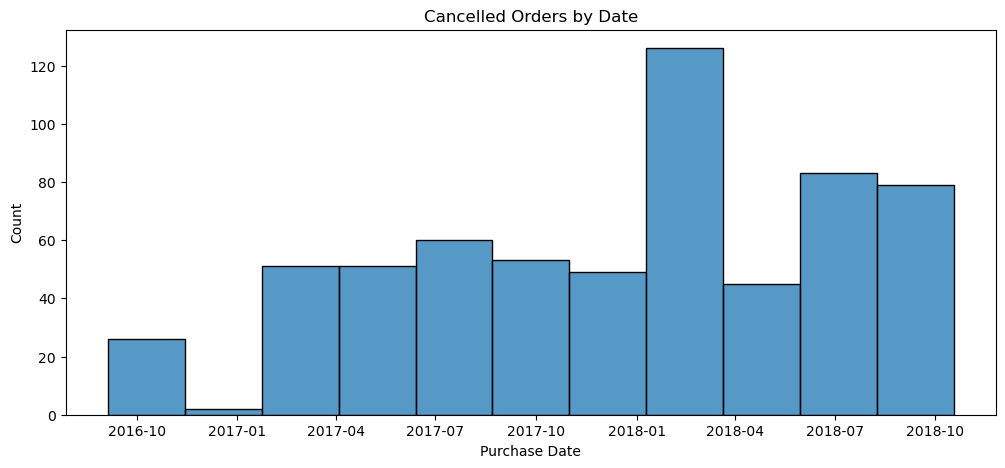

In [7]:
fig, ax = plt.subplots(1,1, figsize=(12,5))

canceled_mask = df_order['order_status'] == 'canceled'
sns.histplot(df_order.loc[canceled_mask, 'order_purchase_timestamp'], ax=ax)
ax.set_title("Cancelled Orders by Date")
ax.set_xlabel("Purchase Date")
plt.show()

#### **Observation:** This finding supports the hypothesis that an increase in missing delivery values is due to a increased purchases, resulting in more cancellations. 
#
#### **Next Step:** Impute delivery time.

In [ ]:
"""
Impute Delivery Dates
"""
from scipy.stats import lognorm

# Calculate delivery time without nulls
df_order['delivery_time'] = df_order['order_delivered_customer_date'].dropna() - df_order['order_purchase_timestamp'].dropna()  
df_order['delivery_time'] = df_order['delivery_time'].dt.days

# Calculate mean and std of delivery time
mask = df_order['delivery_time'].isna()

# Impute missing delivery times 
delivery_mean = df_order['delivery_time'].mean()
delivery_std = df_order['delivery_time'].std()
df_order.loc[mask, 'delivery_time'] = abs(lognorm.rvs(s=delivery_std, scale=np.exp(delivery_mean)))

# Impute customer and carrier date with purchase date plus average delivery time
df_order.loc[customer_missing_mask, 'order_delivered_customer_date'] = df_order.loc[customer_missing_mask, 'order_purchase_timestamp']+ dt.timedelta(days=delivery_mean)
df_order.loc[customer_missing_mask, 'order_delivered_carrier_date'] = df_order.loc[customer_missing_mask, 'order_purchase_timestamp']+ dt.timedelta(days=delivery_mean)

# Missing Values in 'order_approved_at'

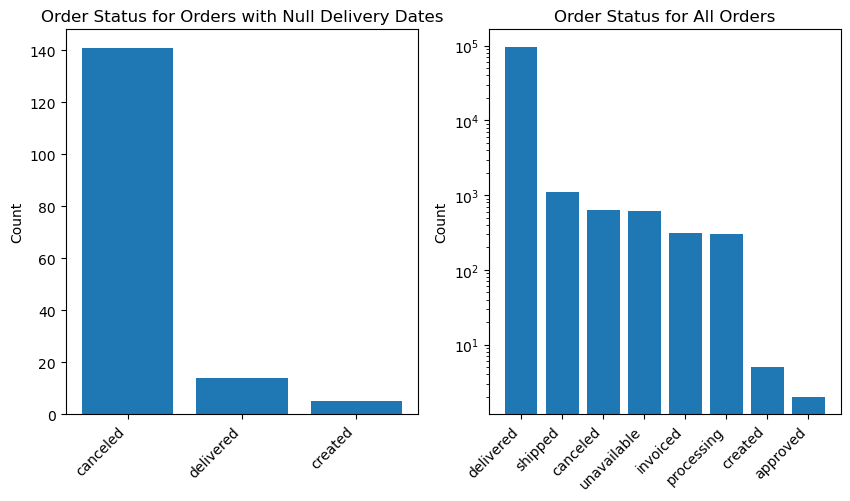

In [9]:
"""
Determining null values in 'order_approved_at' column
"""

fig, ax = plt.subplots(1,2, figsize=(10,5))

df_order_approved_nulls = df_order.loc[df_order['order_approved_at'].isna()]

# Plot cancelled orders with null delivery dates
idx = df_order_approved_nulls.loc[:,"order_status"].value_counts().index
data = df_order_approved_nulls.loc[:,"order_status"].value_counts().values

ax[0].bar(idx, data)
ax[0].set_xticklabels(idx, rotation=45, ha='right')
ax[0].set_ylabel('Count')
ax[0].set_title('Order Status for Orders with Null Delivery Dates')

# Plot all orders by status
idx = df_order.loc[:,"order_status"].value_counts().index
data = df_order.loc[:,"order_status"].value_counts().values

ax[1].bar(idx, data)
ax[1].set_xticklabels(idx, rotation=45, ha='right')
ax[1].set_ylabel('Count')
ax[1].set_title('Order Status for All Orders')
ax[1].set_yscale('log')

plt.show()



#### **Observation:** Most missing values in the "order_approved_at" column occur for orders with a "canceled" status.
#
#### **Hypothesis:** These missing values are likely not missing at random (MNAR), but instead are due to the system's handling of canceled orders, which may skip the approval step.
#
#### **Recommendation:** Investigate the order approval and cancellation workflow to confirm if the process intentionally omits "order_approved_at" for canceled orders.


# Discretize & Feature Engineering
- Customer Purchasing Power
- Add Regions Column

In [10]:
"""
customer (PK: customer_id) -> order (PK: order_id) -> order_item (FK: product_id) -> product (FK: product_id)
customer (PK: customer_id) -> payment (FK: order_id)
"""
merged = pd.merge(df_customer, df_order, on='customer_id', how='inner')
merged = pd.merge(merged, df_order_item, on='order_id', how='inner')
merged = pd.merge(merged, df_product, on='product_id', how='inner')
merged = pd.merge(merged, df_order_payment, on='order_id', how='inner')



In [11]:
from sklearn.preprocessing import KBinsDiscretizer
"""
Discretize Customer Spending
"""

# Group by customer and sum payment value
customer_spending = merged.groupby('customer_id')['payment_value'].sum().to_frame()

# Discretize spending
kbd = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')

# Fit and transform
kbd.fit(customer_spending)
customer_spending['customer_spending'] = kbd.transform(customer_spending)

# Merge with customer dataset
df_customer = pd.merge(df_customer, customer_spending, on='customer_id', how='inner')


In [12]:
"""Add Column for Region in Customer and Geolocation datasets"""

state_to_region = {
    'SP': 'Southeast',
    'MG': 'Southeast',
    'RJ': 'Southeast',
    'ES': 'Southeast',
    'PR': 'South',
    'SC': 'South',
    'RS': 'South',
    'DF': 'Central-West',
    'GO': 'Central-West',
    'MS': 'Central-West',
    'MT': 'Central-West',
    'BA': 'Northeast',
    'SE': 'Northeast',
    'AL': 'Northeast',
    'PE': 'Northeast',
    'PB': 'Northeast',
    'RN': 'Northeast',
    'CE': 'Northeast',
    'PI': 'Northeast',
    'MA': 'Northeast',
    'PA': 'North',
    'AM': 'North',
    'AP': 'North',
    'RO': 'North',
    'AC': 'North',
    'RR': 'North',
    'TO': 'North'
}

df_customer['customer_region'] = df_customer['customer_state'].map(state_to_region)
df_geo['geolocation_region'] = df_geo['geolocation_state'].map(state_to_region)


In [13]:
from sklearn.preprocessing import OneHotEncoder
"""
One Hot Encode Region in Customer Dataset
"""

# Encode Region
encoder = OneHotEncoder()
one_hot_region = encoder.fit_transform(df_customer[['customer_region']])
one_hot_region_df = pd.DataFrame(one_hot_region.toarray(), columns=encoder.get_feature_names_out())

df_customer = pd.concat([df_customer, one_hot_region_df], axis=1)
df_customer

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_value,customer_spending,customer_region,customer_region_Central-West,customer_region_North,customer_region_Northeast,customer_region_South,customer_region_Southeast
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,146.87,0.0,Southeast,0.0,0.0,0.0,0.0,1.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,335.48,1.0,Southeast,0.0,0.0,0.0,0.0,1.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,157.73,0.0,Southeast,0.0,0.0,0.0,0.0,1.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,173.30,0.0,Southeast,0.0,0.0,0.0,0.0,1.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,252.25,1.0,Southeast,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98660,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,88.78,0.0,Southeast,0.0,0.0,0.0,0.0,1.0
98661,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,129.06,0.0,Southeast,0.0,0.0,0.0,0.0,1.0
98662,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,56.04,0.0,Northeast,0.0,0.0,1.0,0.0,0.0
98663,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,711.07,2.0,South,0.0,0.0,0.0,1.0,0.0


In [14]:
# Processed Data
df_order.to_csv('./data/processed/orders_processed.csv', index=False)
df_customer.to_csv('./data/processed/customers_processed.csv', index=False)

# Raw Data
df_geo.to_csv('./data/processed/geolocation.csv', index=False)
df_order_item.to_csv('./data/processed/order_items.csv', index=False)
df_order_payment.to_csv('./data/processed/order_payments.csv', index=False)
df_order_review.to_csv('./data/processed/order_reviews.csv', index=False)
df_product.to_csv('./data/processed/products.csv', index=False)
df_seller.to_csv('./data/processed/sellers.csv', index=False)
df_product_category.to_csv('./data/processed/product_category.csv', index=False)


